#  **Deep Learning for Computer Vision**

### This deep neural network classifies images from the Fashion-MNIST dataset, a collection of 70,000 images of articles of clothing/accessories. It is split into a training set of 65,000 images and a test set of 5,000 images.

### Each image is one of ten possible categories of clothing. This program attempts to identify each one.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from random import randint
import seaborn as sns


mnist = keras.datasets.fashion_mnist  #Fashion-MNIST dataset of clothing images with 28x28 pixels per image


(x_train,y_train),(x_test,y_test) = mnist.load_data() 
x_train, x_test = x_train/255, x_test/255      


clothing_types = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', #Types of clothing (10 types)
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X_train = []
X_test = []

for x in range(len(x_train)):
    X_train.append(x_train[x].reshape(len(x_train[x])**2,1))
    
for i in range(len(x_test)):
    X_test.append(x_test[i].reshape(len(x_test[i])**2,1))
    
X_train = np.array(X_train+X_test[:5000]).squeeze()
X_test = np.array(X_test[5000:]).squeeze()

y_train = np.array(list(y_train)+list(y_test[:5000])).reshape(-1,1)
y_test = y_test[5000:].reshape(-1,1)
    

m = X_train.shape[0]
n = X_train.shape[1]

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


##         A few examples of the images and labels in the dataset:

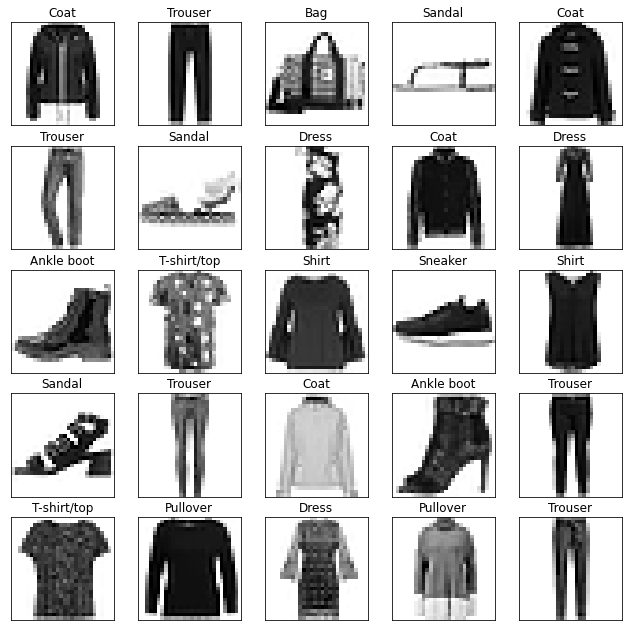

In [2]:
fig = plt.figure(figsize = (11,11))
image_shape = (28,28)

for i in range(1,26):
    img = randint(0,m-1)
    image = X_train[img].reshape(image_shape)
    ax = fig.add_subplot(5,5,i)
    ax.imshow(image,cmap = plt.cm.binary)
    ax.set_xticks(())
    ax.set_yticks(())
    plt.title(clothing_types[int(y_train[img])])

plt.show()

### This cell describes the neural network's architecture and randomly initializes the parameters. The neural network has an input layer of 784 neurons (corresponding to the 24x24 pixels each image contains), three hidden layers containing 500, 400, and 270 neurons, respectively, and the output layer with 10 neurons, corresponding to 10 classes.

In [3]:
L0_units = n
L1_units = 500
L2_units = 400
L3_units = 270
L4_units = len(clothing_types)


# Random initialization of the weights matrices:
W1 = np.random.randn(L1_units,L0_units)/np.sqrt(L0_units)
W2 = np.random.randn(L2_units,L1_units)/np.sqrt(L1_units)
W3 = np.random.randn(L3_units,L2_units)/np.sqrt(L2_units)
W4 = np.random.randn(L4_units,L3_units)/np.sqrt(L3_units)


# Initilization of the bias matrices to 0:
b1 = np.zeros((L1_units,1))
b2 = np.zeros((L2_units,1))
b3 = np.zeros((L3_units,1))
b4 = np.zeros((L4_units,1))



y_matrix = np.identity(len(clothing_types))
y_train_matrix = []

for y in range(len(y_train)):
    y_train_matrix.append(y_matrix[y_train[y]])
    
y_train_matrix = np.array(y_train_matrix)
y_train_matrix = y_train_matrix.squeeze()

y_test_matrix = []

for y in range(len(y_test)):
    y_test_matrix.append(y_matrix[y_test[y]])
    
y_test_matrix = np.array(y_test_matrix)
y_test_matrix = y_test_matrix.squeeze()

### The following functions include functions used to train the model through forward and backward propagation and gradient descent, as well as one used to predict the class of a given image. The network uses leaky ReLU activation functions for the hidden layers and softmax activation for the output.
### The cost function (used for both gradient descent and evaluation) is the categorical cross-entropy cost function.

In [4]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x))



def forward_propagation(X,w1,w2,w3,w4,b1,b2,b3,b4):
    
    Z1 = np.matmul(w1,X.T) + b1    
    A1 = np.maximum(.01,Z1)    
    Z2 = np.matmul(w2,A1) + b2    
    A2 = np.maximum(.01,Z2)    
    Z3 = np.matmul(w3,A2) + b3    
    A3 = np.maximum(.01,Z3)    
    Z4 = np.matmul(w4,A3) + b4     
    Z4 = Z4.T    
    y_hat = np.zeros(Z4.shape)
    
    for i in range(len(y_hat)):
        y_hat[i] = softmax(Z4[i])
        
    Z4 = Z4.T
    y_hat = y_hat.T
    
    return A1, A2, A3, Z1, Z2, Z3, Z4, y_hat



def back_propagation(X, Y_matrix, w1, w2, w3, w4, b1, b2, b3, b4):
    
    m = len(X)
    
    A1, A2, A3, Z1, Z2, Z3, Z4, y_hat = forward_propagation(X,w1,w2,w3,w4,b1,b2,b3,b4)
    
    dZ4 = y_hat - Y_matrix.T    
    dW4 = np.matmul(dZ4,A3.T)/m    
    db4 = np.sum(dZ4, axis = 1, keepdims = True)/m    
    dZ3 = np.matmul(w4.T,dZ4) * (Z3 > .01)    
    dW3 = np.matmul(dZ3,A2.T)/m      
    db3 = np.sum(dZ3, axis = 1, keepdims = True)/m    
    dZ2 = np.matmul(w3.T,dZ3) * (Z2 > .01)    
    dW2 = np.matmul(dZ2,A1.T)/m    
    db2 = np.sum(dZ2, axis = 1, keepdims = True)/m
    dZ1 = np.matmul(w2.T,dZ2) * (Z1 > .01)    
    dW1 = np.matmul(dZ1,X)/m    
    db1 = np.sum(dZ1, axis = 1, keepdims = True)/m
    
    gradients = {'dW1':dW1,'dW2':dW2,'dW3':dW3,'dW4':dW4,'db1':db1,'db2':db2,'db3':db3,'db4':db4}
    
    return gradients



def gradient_descent(W1,W2,W3,W4,b1,b2,b3,b4,gradients,alpha):
    
    W1 = W1 - alpha * gradients['dW1']   
    W2 = W2 - alpha * gradients['dW2']    
    W3 = W3 - alpha * gradients['dW3']    
    W4 = W4 - alpha * gradients['dW4']      
    b1 = b1 - alpha * gradients['db1']
    b2 = b2 - alpha * gradients['db2']
    b3 = b3 - alpha * gradients['db3']
    b4 = b4 - alpha * gradients['db4']
    
    return W1, W2, W3, W4, b1, b2, b3, b4



def predict(df,row, W1, W2, W3, W4, b1, b2, b3, b4):
    
    n = len(df[row])
    
    image = df[row].reshape(n,1)
    
    z1 = np.matmul(W1,image) + b1
    a1 = np.maximum(.01,z1)    
    z2 = np.matmul(W2,a1) + b2
    a2 = np.maximum(.01,z2)
    z3 = np.matmul(W3,a2) + b3
    a3 = np.maximum(.01,z3)
    z4 = np.matmul(W4,a3) + b4
    y_hat = softmax(z4)
    prediction = y_hat.argmax()
    
    return prediction



def cost(x, y_matrix, w1, w2, w3, w4, b1, b2, b3, b4):
        
    A1, A2, A3, Z1, Z2, Z3, Z4, y_hat = forward_propagation(x, w1, w2, w3, w4, b1, b2, b3, b4)
        
    y_hat = y_hat.T    
    J = -np.sum(y_matrix*np.log(y_hat)+(1-y_matrix)*np.log(1-y_hat))/len(x)
    
    return J

### The neural network is ready to be trained using the training examples. The while loop iterates though 3,500 steps of gradient descent (it will take some time.)

In [5]:
training_costs = []
testing_costs = []

iterations = 0
iteration = []
    
while iterations < 3500:
    
    if iterations % 500 == 0:
        
        train_j = cost(X_train, y_train_matrix, W1, W2, W3, W4, b1, b2, b3, b4)
        training_costs.append(train_j)
        
        test_j = cost(X_test, y_test_matrix, W1, W2, W3, W4, b1, b2, b3, b4)
        testing_costs.append(test_j)
        
        iteration.append(iterations)
        
        print(f'Training cost after {iterations} iterations: {train_j}')
        print(f'Validation cost after {iterations} iterations: {test_j}\n')
                
    gradients = back_propagation(X_train, y_train_matrix, W1, W2, W3, W4, b1, b2, b3, b4)    
    alpha = 1/(iterations+1) + .03
    
    W1, W2, W3, W4, b1, b2, b3, b4 = gradient_descent(W1, W2, W3, W4, b1, b2, b3, b4, gradients, .1)
    
    iterations += 1

j_train = cost(X_train, y_train_matrix, W1, W2, W3, W4, b1, b2, b3, b4)
training_costs.append(j_train)

j_test = cost(X_test, y_test_matrix, W1, W2, W3, W4, b1, b2, b3, b4)
testing_costs.append(j_test)

iteration.append(iterations)
print(f'Training cost after 3500 iterations: {j_train}')
print(f'Validation cost after 3500 iterations: {j_test}')

Training cost after 0 iterations: 3.2817145647131367
Validation cost after 0 iterations: 3.2848071822793092

Training cost after 500 iterations: 0.7491226059026859
Validation cost after 500 iterations: 0.8127058663577372

Training cost after 1000 iterations: 0.6519111529434776
Validation cost after 1000 iterations: 0.7285883058863916

Training cost after 1500 iterations: 0.584657663495914
Validation cost after 1500 iterations: 0.6659351172749118

Training cost after 2000 iterations: 0.5327453957886462
Validation cost after 2000 iterations: 0.6396583613519509

Training cost after 2500 iterations: 0.5497005777478581
Validation cost after 2500 iterations: 0.6603085654759816

Training cost after 3000 iterations: 0.45102962205208913
Validation cost after 3000 iterations: 0.5750052819662986

Training cost after 3500 iterations: 0.4464882137927757
Validation cost after 3500 iterations: 0.594919957389941


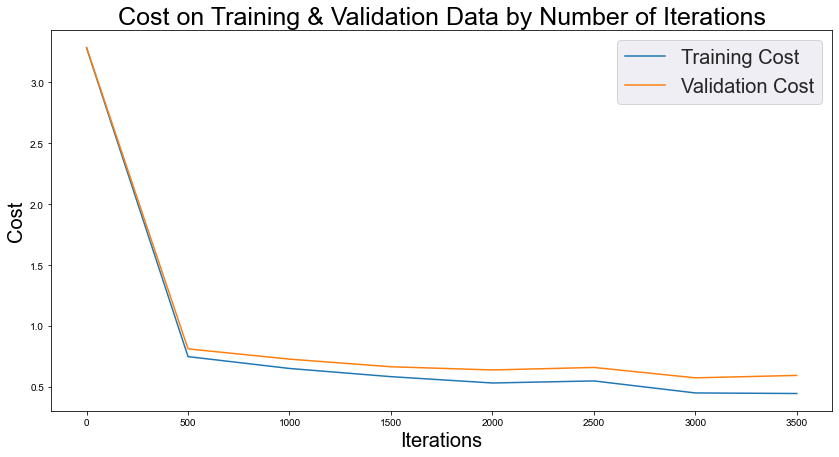

In [6]:
plt.figure(figsize=(14,7))
plt.plot(iteration,training_costs)
plt.plot(iteration, testing_costs)
plt.xlabel('Iterations',fontdict={'fontsize':20})
plt.ylabel('Cost',fontdict={'fontsize':20})
plt.title('Cost on Training & Validation Data by Number of Iterations',fontdict={'fontsize':25})
sns.set_style('darkgrid')
plt.legend(['Training Cost','Validation Cost'],prop={'size':20})
plt.show()

In [7]:
train_data_predictions = []
train_data_actual = []

for i in range(m):
    
    p = predict(X_train, i, W1, W2, W3, W4, b1, b2, b3, b4)
    y = int(y_train[i])
    
    train_data_predictions.append(p)
    train_data_actual.append(y)
    
    
test_data_predictions = []
test_data_actual = []


for i in range(X_test.shape[0]):
    
    p = predict(X_test, i, W1, W2, W3, W4, b1, b2, b3, b4)
    y = int(y_test[i])
    
    test_data_predictions.append(p)
    test_data_actual.append(y)

###  Finally, we can see how well the neureal network performed on both the training set and the test set:

In [8]:
train_accuracy = accuracy_score(train_data_actual,train_data_predictions)
test_accuracy = accuracy_score(test_data_actual,test_data_predictions)

print('Accuracy on training set: ' + str(round(train_accuracy,2)))
print('\nAccuracy on test set: ' + str(round(test_accuracy,2)))

Accuracy on training set: 0.91

Accuracy on test set: 0.88


### To put the model on display, let's see how well it interprets 25 images form the test set. The prediction is above the image and the actual label is below.

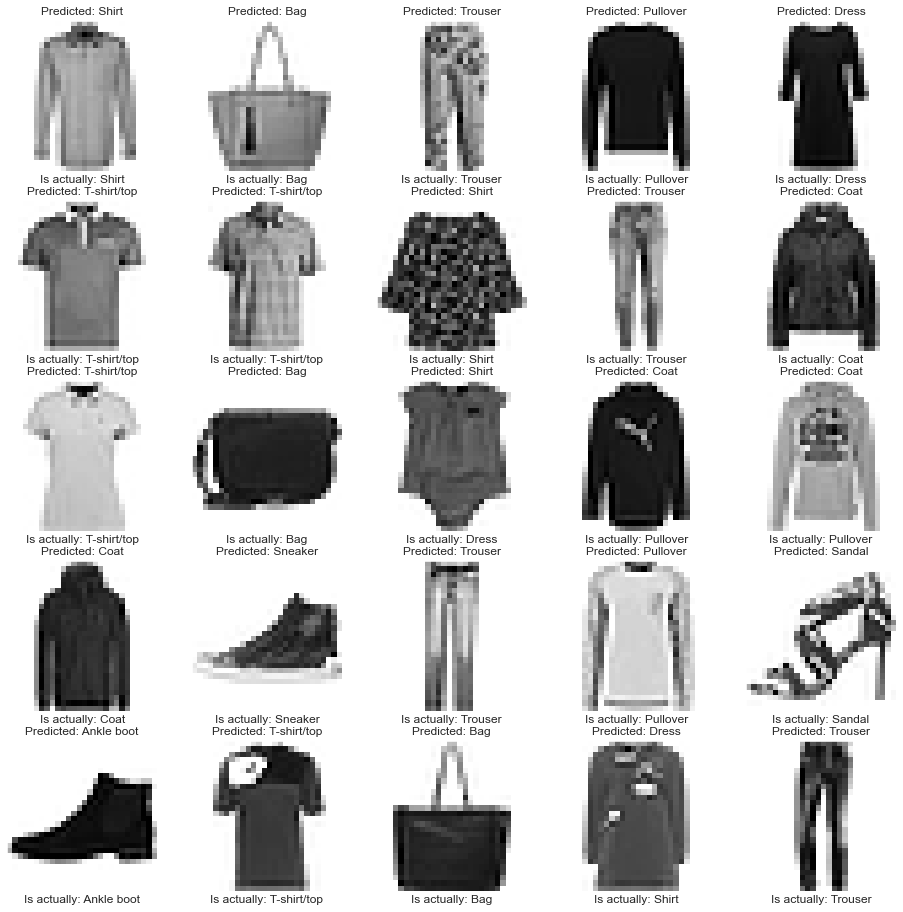

In [9]:
fig = plt.figure(figsize=(16,16))

for i in range(1,26):
    
    num = randint(0,X_test.shape[0]-1)
    predicted_class = clothing_types[predict(X_test, num, W1, W2, W3, W4, b1, b2, b3, b4)]
    correct_class = clothing_types[int(y_test[num])]    
    img = X_test[num].reshape(image_shape)
    fig.add_subplot(5,5,i)
    plt.imshow(img,cmap = plt.cm.binary)
    plt.title('Predicted: '+predicted_class)
    plt.xlabel('Is actually: '+correct_class,fontdict={'fontsize':12})
    plt.xticks(())
    plt.yticks(())
    
plt.show()